<a href="https://colab.research.google.com/github/marsred/The_School_Of_AI/blob/master/Session2/assignment_using_gap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import Libraries and modules**

In [0]:
# https://keras.io/
!pip install -q keras
import keras

In [0]:
import numpy as np

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Add, BatchNormalization, GlobalAveragePooling2D
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils

from keras.datasets import mnist

### Load pre-shuffled MNIST data into train and test sets

In [0]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

(60000, 28, 28)


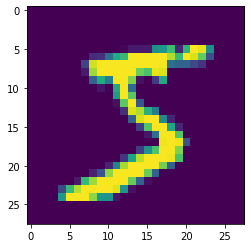

In [30]:
print (X_train.shape)
from matplotlib import pyplot as plt
%matplotlib inline
plt.imshow(X_train[0])

In [0]:
X_train = X_train.reshape(X_train.shape[0], 28, 28,1)
X_test = X_test.reshape(X_test.shape[0], 28, 28,1)

In [32]:
print (X_train.shape)
#print (X_train[:10])

(60000, 28, 28, 1)


In [0]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

In [0]:
y_train[:10]

array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4], dtype=uint8)

In [0]:
# Convert 1-dimensional class arrays to 10-dimensional class matrices
Y_train = np_utils.to_categorical(y_train, 10)
Y_test = np_utils.to_categorical(y_test, 10)

In [0]:
Y_train[:10]


array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]], dtype=float32)

In [40]:
from keras.layers import Activation
model = Sequential()

 
model.add(Convolution2D(10, 3, 3, activation='relu', input_shape=(28,28,1), use_bias=False)) # 26
model.add(BatchNormalization())
model.add(Dropout(0.1))

model.add(Convolution2D(16, 3, activation='relu', use_bias=False)) # 24
model.add(BatchNormalization())
model.add(Dropout(0.1))

model.add(Convolution2D(32, 3, activation='relu', use_bias=False)) # 22
model.add(BatchNormalization())
model.add(Dropout(0.1))

model.add(MaxPooling2D(2)) # 11

model.add(Convolution2D(16, 1, activation='relu', use_bias=False)) # 11
model.add(BatchNormalization())
model.add(Dropout(0.1))

model.add(Convolution2D(16, 3, activation='relu', use_bias=False)) # 9
model.add(BatchNormalization())
model.add(Dropout(0.1))

model.add(Convolution2D(10, 3, activation='relu', use_bias=False)) # 7
model.add(BatchNormalization())
model.add(Dropout(0.1))

model.add(Convolution2D(10, 3, activation='relu', use_bias=False)) # 5
model.add(BatchNormalization())
model.add(Dropout(0.1))

model.add(GlobalAveragePooling2D())

#model.add(Convolution2D(10, 5, use_bias=False)) # 1

#model.add(Flatten())
model.add(Activation('softmax'))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(10, (3, 3), activation="relu", input_shape=(28, 28, 1..., use_bias=False)`
  """


In [41]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_37 (Conv2D)           (None, 26, 26, 10)        90        
_________________________________________________________________
batch_normalization_34 (Batc (None, 26, 26, 10)        40        
_________________________________________________________________
dropout_34 (Dropout)         (None, 26, 26, 10)        0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 24, 24, 16)        1440      
_________________________________________________________________
batch_normalization_35 (Batc (None, 24, 24, 16)        64        
_________________________________________________________________
dropout_35 (Dropout)         (None, 24, 24, 16)        0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 22, 22, 32)       

In [0]:
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler
def scheduler(epoch, lr):
  return round(0.003 * 1/(1 + 0.319 * epoch), 10)

model.compile(loss='categorical_crossentropy',
             optimizer=Adam(lr=0.003),
             metrics=['accuracy'])

In [43]:
model.fit(X_train, Y_train, batch_size=32, nb_epoch=20, verbose=1, validation_data=(X_test, Y_test), 
          callbacks=[LearningRateScheduler(scheduler, verbose=1)])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 60000 samples, validate on 10000 samples
Epoch 1/20

Epoch 00001: LearningRateScheduler setting learning rate to 0.003.
60000/60000 [==============================] - 43s 716us/step - loss: 0.3057 - acc: 0.9363 - val_loss: 0.0673 - val_acc: 0.9827
Epoch 2/20

Epoch 00002: LearningRateScheduler setting learning rate to 0.0022744503.
60000/60000 [==============================] - 40s 660us/step - loss: 0.1068 - acc: 0.9726 - val_loss: 0.0343 - val_acc: 0.9908
Epoch 3/20

Epoch 00003: LearningRateScheduler setting learning rate to 0.0018315018.
60000/60000 [==============================] - 40s 661us/step - loss: 0.0843 - acc: 0.9769 - val_loss: 0.0347 - val_acc: 0.9900
Epoch 4/20

Epoch 00004: LearningRateScheduler setting learning rate to 0.0015329586.
60000/60000 [==============================] - 39s 653us/step - loss: 0.0712 - acc: 0.9808 - val_loss: 0.0268 - val_acc: 0.9921
Epoch 5/20

Epoch 00005: LearningRateScheduler setting learning rate to 0.0013181019.
60000/60000 [==

In [0]:
score = model.evaluate(X_test, Y_test, verbose=0)

In [0]:
print(score)

[0.02138314440062095, 0.9933]
